In [13]:
import pandas as pd
import numpy as np
import datetime, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import random

In [123]:
driftNumber = 20
totalSeconds = 10*60
DIST_MEAN = 2.8

In [124]:
def plot_data(df, driftsExtra=None,driftShow=True, save_fig=None):
    fig = plt.figure(figsize=(12,4), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 3])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax1.grid()
    ax2.grid()
    ax1.plot(df["latency"], label='Stream')
    ax1.set_ylabel('latency')
    ax2.plot(df["latency"], label='Stream')
    ax2.set_ylabel('latency')
    drifts= list(df.query("drift == 1").index)
    if len(drifts) > 0:
        for i in drifts:
            ax2.axvline(i, color='red')
    if driftsExtra and driftShow:
        for i in driftsExtra:
            ax1.axvline(i, color='yellow')
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

In [125]:
def get_unix(latency):
    millisecond = datetime.datetime.now() - datetime.timedelta(seconds=latency)
    unixtimestamp = int(millisecond.timestamp() * 1000)
    return unixtimestamp

In [126]:
def check_items(arr, min_diff=10):
    for index, el in enumerate(arr):
        if index < len(arr)-1:
            diff = arr[index+1] - arr[index]
            if diff < min_diff:
                return False
    return True
        
    

In [132]:
def generate_new_mean(old_mean):
    while True:
        temp = random.uniform(2, 5)
        if abs(temp - old_mean) > 0.99:
            break
    return temp
            
            

In [133]:

def generate_drift(driftNumber,totalSeconds, mean):
    sd=0.5
    random_state = np.random.RandomState(seed=42)
    random.seed(42)
    df = pd.DataFrame({'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'latency': pd.Series(dtype='float'),
                   'drift': pd.Series(dtype='int')})
    
    while True:
        drifts = sorted(random.sample(range(totalSeconds), driftNumber))
        if check_items(drifts):
            break


    changePoints = []
    now = datetime.datetime.now()
    endTime = now + datetime.timedelta(seconds=totalSeconds)
    for i in drifts:
        changePoints.append(now + datetime.timedelta(seconds=i))


    # generate
    drift = 0
    driftCounter = 0
    while True:
      # end for loop
      if datetime.datetime.now() >= endTime:
        break
      if drift == 1:
        drift = 0

      # drift
      now = datetime.datetime.now()
      if driftCounter < driftNumber-1:
          if now >= changePoints[driftCounter] and now < changePoints[driftCounter + 1]:
            mean = generate_new_mean(mean)
            drift = 1
            driftCounter += 1


      if driftCounter == driftNumber-1  and now >= changePoints[driftCounter] and now < endTime:
        mean = generate_new_mean(mean)
        drift = 1
        driftCounter += 1

      # write
      payload = random_state.normal(mean, sd)
      unix_event = get_unix(payload)
      unix_ingestion = get_unix(0)
      df = df.append({"ingestion":int(unix_ingestion), "event": int(unix_event),"latency":payload, "drift": int(drift)},ignore_index=True)
      #wait 
      time.sleep(.01)
    return df
    

In [134]:
df = generate_drift(driftNumber, totalSeconds, DIST_MEAN)

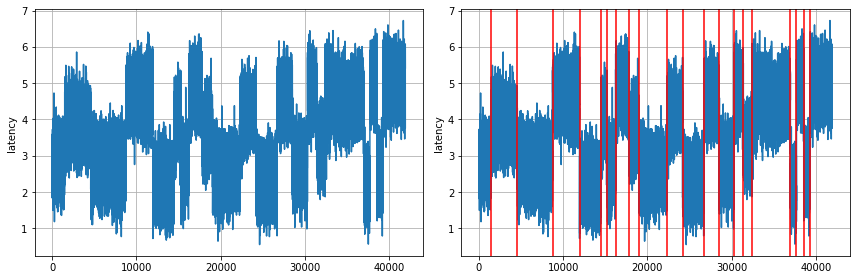

In [136]:
plot_data(df,driftShow=True)



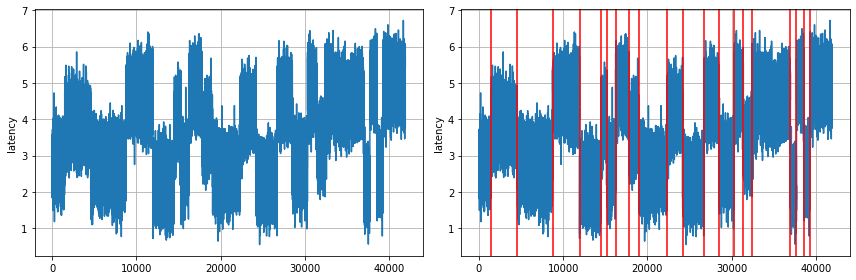

In [137]:
plot_data(df,driftShow=True, save_fig="drift_20.png")


In [139]:
df.to_csv(f"conceptdrift/Data/data_drift_{driftNumber}.csv",index=False,header=None)